# Spectrum and light curve from DL3

This notebook must be used with a gammapy version v0.20 or higher. Here we will use the following conda environment: `conda activate gammapy-v1.0`. We will then fit the SED with a LogParabola model given by  

## $ \Phi =  \Phi_0 \left(\frac{E}{E_{ref}}\right)^{\alpha + \beta\log_{10}(E/E_{ref})}     $

where we compare it with the archival Crab spectrum, which has $\Phi_0 = 3.23\times 10^{-11}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$, $E_{ref} = 1$ TeV, $\alpha = -2.47$, and $\beta = -0.24$.



### Loading some modules

In [1]:
# packages
import numpy             as np 
import matplotlib.pyplot as plt
import pandas            as pd
import yaml, os, logging, sys
pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, '/fefs/aswg/workspace/juan.jimenez/stereo_analysis/scripts')
import auxiliar as aux
aux.params()

import itertools
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion, PointSkyRegion
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from datetime import datetime, timedelta

# --- all gammapy sub-packages --- #
import gammapy
print(f"gammapy: v{gammapy.__version__}")
from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
)
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.estimators import FluxPoints
# -------------------------------- #

plt.rcParams['lines.linewidth'] = 1.5

gammapy: v1.0


## Selecting parameters
We will do the analysis with two different datasets:
- **MAGIC+LST performance paper dataset**
- **Data processed in this work**

In [2]:
# --- other parameters --- #
# name of the source we are studying
source_name = 'Crab'
# ------------------------ #

# --- data reduction parameters --- #
energy_min = '0.040 TeV'
energy_max = '25. TeV'
n_bins_pdec = 5

true_energy_min = '0.01 TeV'
true_energy_max = '100 TeV'
n_bins_pdec_true = 10

n_off_regions = 3
# --------------------------------- #

# --- SED function parameters --- #
sed_type = 'e2dnde'
yunits   = u.Unit('erg cm-2 s-1')

crab_model = create_crab_spectral_model('magic_lp')

# print(crab_model)
reference_models = {'Crab reference (MAGIC, JHEAp 2015)': crab_model,}
# ------------------------------- #


# --- file paths --- #
# dl3 files
input_dirs     = ['/fefs/aswg/workspace/juan.jimenez/data/dl3_Crab/']

fermi_lat_sed_file = '/fefs/aswg/workspace/juan.jimenez/data/other_results/SED_Crab_FermiLAT_Arakawa2020.fits'
# ------------------ #


# some colours
colors = ['darkblue', 'darkorange', 'deeppink', 'darkviolet', 'crimson']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

### Reading and opening the provided `dl3` files

In [3]:
data_stored = [DataStore.from_dir(input_dir) for input_dir in input_dirs]

# show the observation table
for data, input_dir, i in zip(data_stored, input_dirs, range(len(input_dirs))):
    print(f'\nOpening {len(data.obs_table.to_pandas())} files-runs from {input_dir}.')
    obs_ids = data.obs_table.to_pandas()['OBS_ID'].to_numpy()
    print(f'The runs analysed in {i+1}# dataset are:\n{obs_ids}')
    display(data.obs_table.to_pandas().head(4))


Opening 44 files-runs from /fefs/aswg/workspace/juan.jimenez/data/dl3_Crab/.
The runs analysed in 1# dataset are:
[2923 3265 3266 3267 3268 3382 3383 3385 3631 3632 3633 3634 3635 3636
 3955 3956 4011 4012 4013 4014 4125 4126 7171 7198 7200 7201 7227 7228
 7229 7230 7231 7232 7233 7234 7235 7236 7237 7238 7255 7256 7277 7278
 7279 7282]


,OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
0,2923,b'2020-11-18',b'23:35:47.054',b'2020-11-18',b'23:52:39.650',83.965582,22.246383,45.061817,44.938183,86.404262,83.6333,22.0133,1.605743e+09,1.605744e+09,361.540171,1012.595825,327.730966,0.906486,b'Crab',b'WOBBLE',3,b'LST1_M1_M2',b'LST1_M1_M2'
1,3265,b'2020-12-15',b'21:27:18.722',b'2020-12-15',b'21:41:43.116',83.964766,22.247814,49.948381,40.051619,84.081655,83.6333,22.0133,1.608068e+09,1.608069e+09,377.947180,864.393870,359.643087,0.951570,b'Crab',b'WOBBLE',3,b'LST1_M1_M2',b'LST1_M1_M2'
2,3266,b'2020-12-15',b'21:43:24.497',b'2020-12-15',b'21:57:30.340',83.263007,21.787702,45.962274,44.037726,86.641861,83.6333,22.0133,1.608069e+09,1.608069e+09,381.712842,845.843447,363.603818,0.952559,b'Crab',b'WOBBLE',3,b'LST1_M1_M2',b'LST1_M1_M2'
3,3267,b'2020-12-15',b'21:59:19.731',b'2020-12-15',b'22:12:55.664',83.966751,22.246063,42.935176,47.064824,87.455726,83.6333,22.0133,1.608070e+09,1.608070e+09,363.771112,815.932556,346.981570,0.953846,b'Crab',b'WOBBLE',3,b'LST1_M1_M2',b'LST1_M1_M2'


### - Extracting Gammapy objects "Observation"
Containing a lot of information (e.g.: events, hdu tables, meta data,...).

### - Define the ON regions

Here we will collect the target position from observations metadata. To define the `on_region` we use `CircleSkyRegion` in case of global theta cuts, `PointSkyRegion` in case of dynamic theta cuts.

In [4]:
observations    = [data.get_observations(None, required_irf='point-like') for data in data_stored]

on_regions, target_positions = [], []
for i in range(len(observations)):
    
    # getting the metadata from the first run
    first_observation = observations[i][0]
    event_meta = first_observation.events.table.meta
    aeff_meta  = first_observation.aeff.meta

    # collecting the target position
    target_position = SkyCoord(
        u.Quantity(event_meta['RA_OBJ'],  u.deg),
        u.Quantity(event_meta['DEC_OBJ'], u.deg),
        frame='icrs',)
    target_positions.append(target_position)

    # global theta cuts
    if 'RAD_MAX' in aeff_meta:
        # get the global theta cut used for creating the IRFs
        on_region_radius = aeff_meta['RAD_MAX'] * u.deg

        # use the circle sky region to apply the global theta cut
        on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
        on_regions.append(on_region)
        print(f'\nPosition of the {i+1}# ON region (using global theta cuts): \n', on_region)

    # dynamic theta cuts
    else:
        # use the point sky region to apply dynamic theta cuts
        on_region = PointSkyRegion(target_position)
        on_regions.append(on_region)
        print(f'\nPosition of the {i+1}# ON region (using dynamic theta cuts): \n', on_region)


Position of the 1# ON region (using global theta cuts): 
 Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333, 22.0133)>
radius: 0.2 deg


### Running the data reduction chain

- Here we create the energy axes (reconstructed and true energy) and we set the number of OFF regions.
- We also create the Gammapy **Makers** needed to process the data.

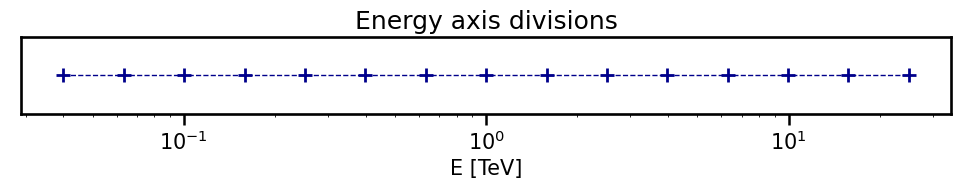


Creating geometry for 1# region
Number of OFF regions: 3


In [5]:
# ------- energy axis ------- #

# getting the energy axis
energy_axis = MapAxis.from_energy_bounds(
    energy_min,
    energy_max,
    nbin=n_bins_pdec,
    per_decade=True,
    name='energy',)

# getting true energy axis (MC data)
energy_axis_true = MapAxis.from_energy_bounds(
    true_energy_min,
    true_energy_max,
    nbin=n_bins_pdec_true,
    per_decade=True,
    name='energy_true',)

fig, ax = plt.subplots(figsize=(12,1))
ax.plot(energy_axis.edges, np.zeros(len(energy_axis.edges)), '+--', lw=1, ms=10)
ax.set_xscale('log')
ax.set_title('Energy axis divisions')
ax.set_yticks([])
ax.set_xlabel('E [TeV]')
plt.show()

# ------ creating the makers ------ #

# creating empty datasets for each object
on_geoms, datasets_empty        = [], []
dataset_makers, bkg_makers, safe_mask_makers = [], [], []

# iterate over datasets
for i, on_region in zip(range(len(on_regions)), on_regions):
    
    print(f'\nCreating geometry for {i+1}# region')
    
    # create ON region geometry
    on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])
    on_geoms.append(on_geom)

    dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)
    datasets_empty.append(dataset_empty)
    
    # create a spectrum dataset maker
    dataset_maker = SpectrumDatasetMaker(
        containment_correction=False,
        selection=['counts', 'exposure', 'edisp'],
        use_region_center=True,)
    dataset_makers.append(dataset_maker)

    # create a background maker
    print(f'Number of OFF regions: {n_off_regions}')

    # finding the OFF regions
    region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
    bkg_maker     = ReflectedRegionsBackgroundMaker(region_finder=region_finder)
    bkg_makers.append(bkg_maker)
    
    # create a safe mask maker
    safe_mask_maker = SafeMaskMaker(methods=['aeff-max'], aeff_percent=10)
    safe_mask_makers.append(safe_mask_maker)

### Applying the makers

Now we apply the makers to the observations to create new datasets that contain the number of events, number of excess and background events, exposure and $\delta = 1/R_{OFF}$, where $R_{OFF}$ is the number of OFF regions. We will use this $\delta$ later to compute the Li & Ma significance.


In [6]:
datasets    = [Datasets()                                  for target_position in target_positions] 
counts      = [Map.create(skydir=target_position, width=3) for target_position in target_positions]

info_tables = []
for i in range(len(observations)):
    
    # Loop over every observation
    print('Running the makers...')

    n_observations = len(observations[i])

    for i_obs, obs in enumerate(observations[i]):

        if (i_obs % 10) == 0:
            print(f'{i_obs}/{n_observations}')

        obs_id = obs.obs_id

        # Fill the number of events in the map
        counts[i].fill_events(obs.events)

        # Run the makers to the observation data
        dataset        = dataset_makers[i].run(  datasets_empty[i].copy(name=str(obs_id)), obs)
        dataset_on_off = bkg_makers[i].run(      dataset, obs)
        dataset_on_off = safe_mask_makers[i].run(dataset_on_off, obs)

        datasets[i].append(dataset_on_off)
        
    print(f'{n_observations}/{n_observations}')

    # Get the information table
    info_table = datasets[i].info_table(cumulative=True)
    info_tables.append(info_table)

    # Show the table
    display(info_table.to_pandas().head(5))


Running the makers...
0/44
10/44
20/44
30/44
40/44
44/44


,name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
0,stacked,302,246.666656,18.003993,55.333336,117.000003,117.000003,NaN,620.592224,2.802178e+08,917.903553,1012.595825,0.329011,0.060282,0.268728,14,11,wstat,345.145979,166,11.0,33.0,0.333333
1,stacked,477,398.000000,23.480555,79.000000,178.500004,178.500004,NaN,620.592224,6.074629e+08,1740.434574,1876.989694,0.274069,0.045391,0.228679,14,11,wstat,580.472650,237,11.0,33.0,0.333333
2,stacked,700,591.000000,29.049109,109.000000,256.750010,256.750010,NaN,620.592224,8.679871e+08,2546.149953,2722.833142,0.274925,0.042810,0.232115,14,11,wstat,881.144314,327,11.0,33.0,0.333333
3,stacked,987,815.666626,33.212620,171.333344,375.250021,375.250021,NaN,2193.022705,1.087909e+09,3324.423847,3538.765698,0.296894,0.051538,0.245356,14,11,wstat,1161.577983,514,11.0,33.0,0.333333
4,stacked,1250,1018.000000,36.446940,232.000000,486.500033,486.500033,NaN,5171.354492,1.266862e+09,4064.416926,4314.685253,0.307547,0.057081,0.250466,14,11,wstat,1405.355191,696,11.0,33.0,0.333333


### Sky map

Let's create a counts map showing also the ON-OFF regions.
In the legend we list the run number for each set of OFF regions.

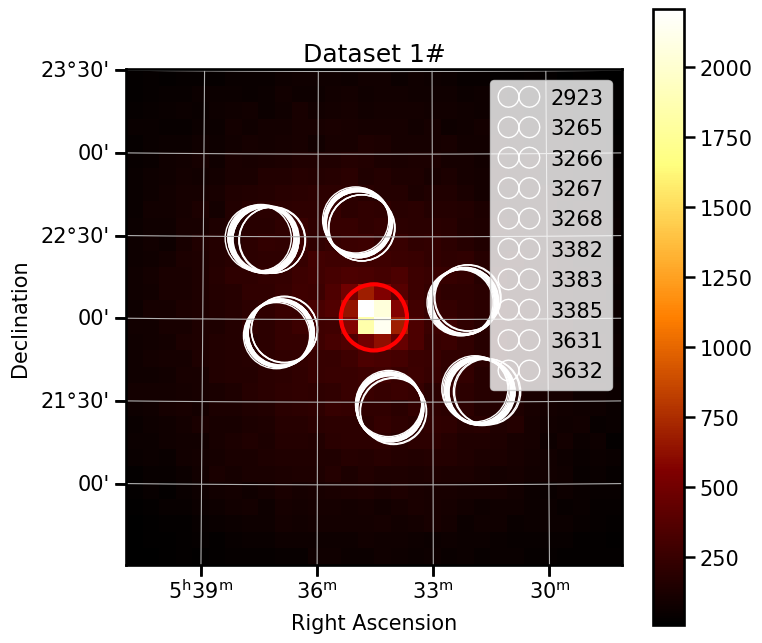

In [7]:
for i in range(len(counts)):
    fig = plt.figure(figsize=(8,8))

    # Plot the count map
    ax = counts[i].plot(add_cbar=True)

    # Plot the ON position
    on_geoms[i].plot_region(ax=ax, edgecolor='r', lw=3)

    # Plot the OFF positions (only the first part of observations)
    plot_spectrum_datasets_off_regions(datasets[i][:10], ax, edgecolor='w', legend=True, 
                                      prop_cycle=plt.cycler(color=list('w'*100)))
    plot_spectrum_datasets_off_regions(datasets[i][10:], ax, edgecolor='w', legend=False, 
                                      prop_cycle=plt.cycler(color=list('w'*100)))

    ax.set_title(f'Dataset {i+1}#')
    ax.grid()
    plt.tick_params(axis='x', which='both', bottom=True, top=False)
    plt.tick_params(axis='y', which='both', left=True, right=False)
    plt.show()

### Excess significance

Now let's plot the number of events and significance (i.e. sqrt(TS), in $\sigma$ units) as a function of livetime, which is the total amount of usefull time collecting data from the target, i.e. livetime $= t_{on} - t_{dead}$.

As expected, the number of excess events (and so the significance) increase faster than the background in terms of the livetime, reaching a 50 $\sigma$ significance in less than 2 hours.

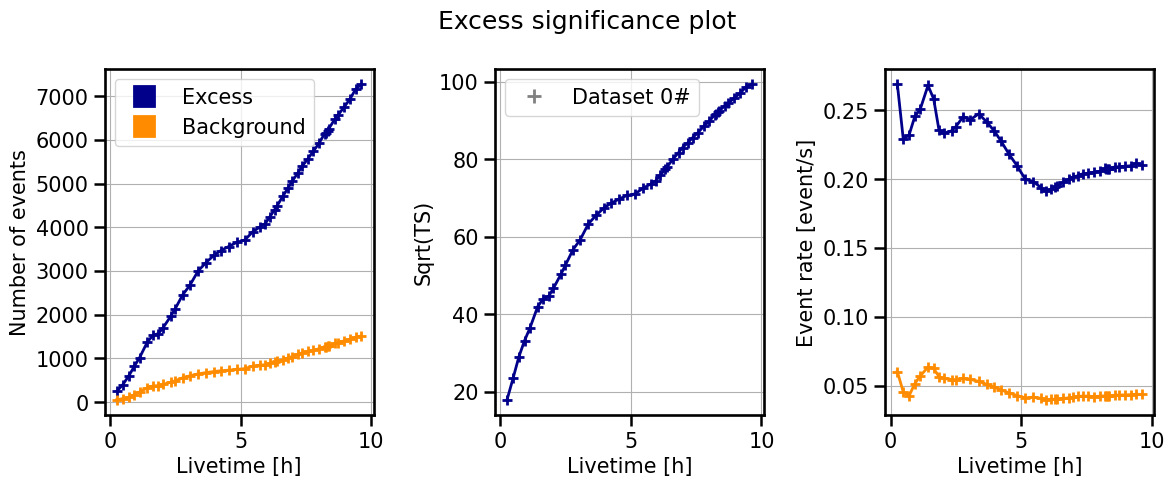

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

markers = ['+' if i%2 == 0 else '^' for i in range(len(datasets))]
for i in range(len(datasets)):

    # plot the number of events along the livetime
    ax1.plot(info_tables[i]['livetime'].to('h'), info_tables[i]['excess'],     marker=markers[i], ls='-', lw=2, c='darkblue', ms=7)
    ax1.plot(info_tables[i]['livetime'].to('h'), info_tables[i]['background'], marker=markers[i], ls='-', lw=2, c='darkorange', ms=7)
#     ax1.plot(info_tables[i]['livetime'].to('h'), info_tables[i]['npred_background'], marker=markers[i], ls='-', lw=2, c='deeppink', ms=7)

    # Plot the significance along the livetime
    ax2.plot(info_tables[i]['livetime'].to('h'), info_tables[i]['sqrt_ts'], marker=markers[i], ls='-', lw=2, c='darkblue', ms=7)

    # plot the number of events along the livetime
    ax3.plot(info_tables[i]['livetime'].to('h'), info_tables[i]['excess_rate'],     marker=markers[i], ls='-', lw=2, c='darkblue', ms=7)
    ax3.plot(info_tables[i]['livetime'].to('h'), info_tables[i]['background_rate'], marker=markers[i], ls='-', lw=2, c='darkorange', ms=7)
    
    ax2.plot([], [], marker=markers[i], ls='', ms=10, lw=2, label=f'Dataset {i}#', color='gray')

ax1.plot([], [], 's', ms=14, color='darkblue', label='Excess')
ax1.plot([], [], 's', ms=14, color='darkorange', label='Background')
# ax1.plot([], [], 's', ms=14, color='deeppink', label='npred background')

fig.suptitle(f'Excess significance plot')
ax1.set_ylabel('Number of events')
ax2.set_ylabel('Sqrt(TS)')
ax3.set_ylabel('Event rate [event/s]')
ax1.legend()
ax2.legend()
for ax in [ax1, ax2, ax3]:    
    ax.set_xlabel('Livetime [h]')
    ax.grid()
fig.tight_layout()
plt.show()

### Fitting the spectrum

* We now fit the LogParabola model defined in the top of this notebook to our data. We start by creating a `SkyModel` and adding it to our datasets, we create a `Fit` that we will run on our data.
* Here we apply the `fit` on the first sample to get the LogParabola parameters.

In [9]:
spectral_model = LogParabolaSpectralModel(
    amplitude=u.Quantity(5e-12, unit='cm-2 s-1 TeV-1'),
    alpha=2,
    beta=0.1,
    reference=u.Quantity(1, unit='TeV'))

sky_model    = SkyModel(spectral_model=spectral_model.copy(),    name=source_name)

# # add the model to the stacked dataset
stacked_datasets = []

for dataset in datasets:
    stacked_dataset = dataset.stack_reduce()
    stacked_dataset.models = [sky_model]
    stacked_datasets.append(stacked_dataset)

# Create a fit object to run on the datasets
fit = Fit()

results, best_fit_models = [], []
for i, stacked_dataset in zip(range(len(stacked_datasets)), stacked_datasets):
    result = fit.run(datasets=stacked_dataset)
    results.append(result)
    print(f'\nFor {i+1}# datset:\n', result)

    # Keep the best fit model
    best_fit_model = stacked_dataset.models[0].spectral_model.copy()
    best_fit_models.append(best_fit_model)
    
    # Show the fitted parameters
    display(stacked_dataset.models.to_parameters_table().to_pandas())


For 1# datset:
 OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 162
	total stat : 5.24

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



,model,type,name,value,unit,error,min,max,frozen,is_norm,link
0,Crab,spectral,amplitude,3.104332e-11,cm-2 s-1 TeV-1,6.195859e-13,NaN,NaN,False,True,
1,Crab,spectral,reference,1.000000e+00,TeV,0.000000e+00,NaN,NaN,True,False,
2,Crab,spectral,alpha,2.536325e+00,,1.853047e-02,NaN,NaN,False,False,
3,Crab,spectral,beta,1.279865e-01,,1.192228e-02,NaN,NaN,False,False,


### Compare observations vs predictions
Now let's check if the observations are in good agreement with the predictions. We do it by plotting the number of excess events and comparing it to the number of predicted events.

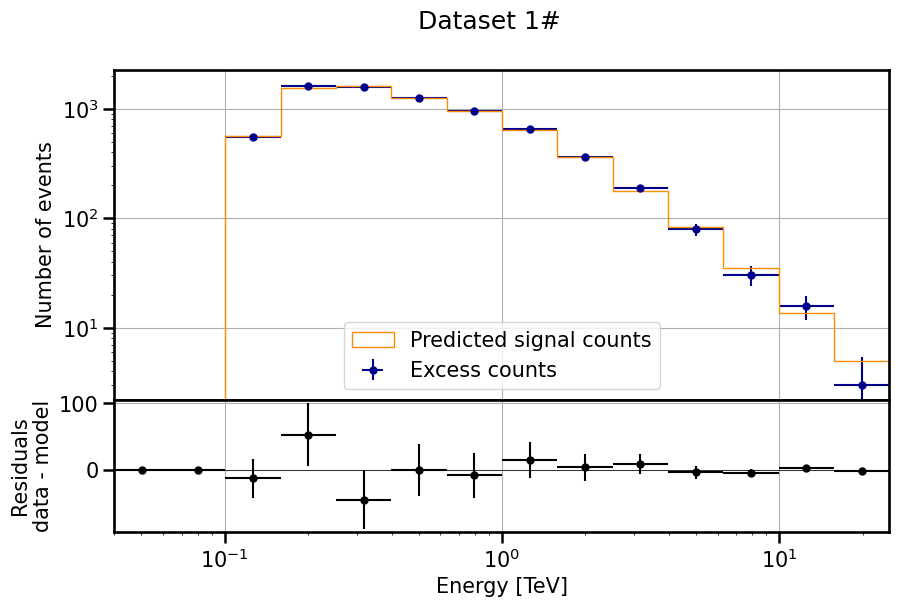

In [10]:
for i in range(len(datasets)):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # plot the number of excess and predicted events
    kwargs_residuals = {'color': 'k'}
    ax_spectrum, ax_residuals = stacked_datasets[i].plot_fit(kwargs_residuals=kwargs_residuals)

    ax_spectrum.set_ylabel('Number of events')
    ax_spectrum.grid()

    plt.setp(ax_spectrum.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

    fig.suptitle(f'Dataset {i+1}#')
    ax_residuals.grid()
plt.show()

### Estimating the flux points

We create a `FluxPointsEstimator` object to be applied on our datasets in order to evaluate the SEDs (`sed_type="e2dnde"`)

In [11]:
# create a flux point estimator
flux_points_estimator = FluxPointsEstimator(energy_edges=energy_axis.edges, source=source_name, selection_optional='all')

# Run the flux point estimator to the datasets
print('Running the flux points estimator...')
flux_points = []
for i in range(len(stacked_datasets)):
    
    print(f'\nFor {i+1}# dataset:')
    flux_point = flux_points_estimator.run(datasets=stacked_datasets[i])
    flux_points.append(flux_point)
    
    # show the flux points table
    display(flux_point.to_table(sed_type='e2dnde', formatted=True)[:5])

Running the flux points estimator...

For 1# dataset:


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.050,0.040,0.063,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.080,0.063,0.100,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.126,0.100,0.159,5.308e-11,2.813e-12,2.842e-12,2.786e-12,5.884e-11,530.730,23.038,790.816887056468,556.1321,0.000,False,791.0,True,0.200 .. 5.000,310.727 .. 2400.305
0.200,0.159,0.252,5.476e-11,1.620e-12,1.630e-12,1.609e-12,5.805e-11,1825.952,42.731,2101.9730674956295,1609.6376,0.000,False,2102.0,True,0.200 .. 5.000,1095.159 .. 6478.551
0.317,0.252,0.399,4.713e-11,1.329e-12,1.338e-12,1.319e-12,4.982e-11,2236.608,47.293,1859.0235691849518,1568.6914,0.000,False,1859.0,True,0.200 .. 5.000,1268.001 .. 7380.669


### Computing the SED

Below we show the SEDs for the two datasets in the same plot, showing the flux points and best fit models. For comparison, we plot the Crab reference SED (MAGIC, JHEAp 2015).

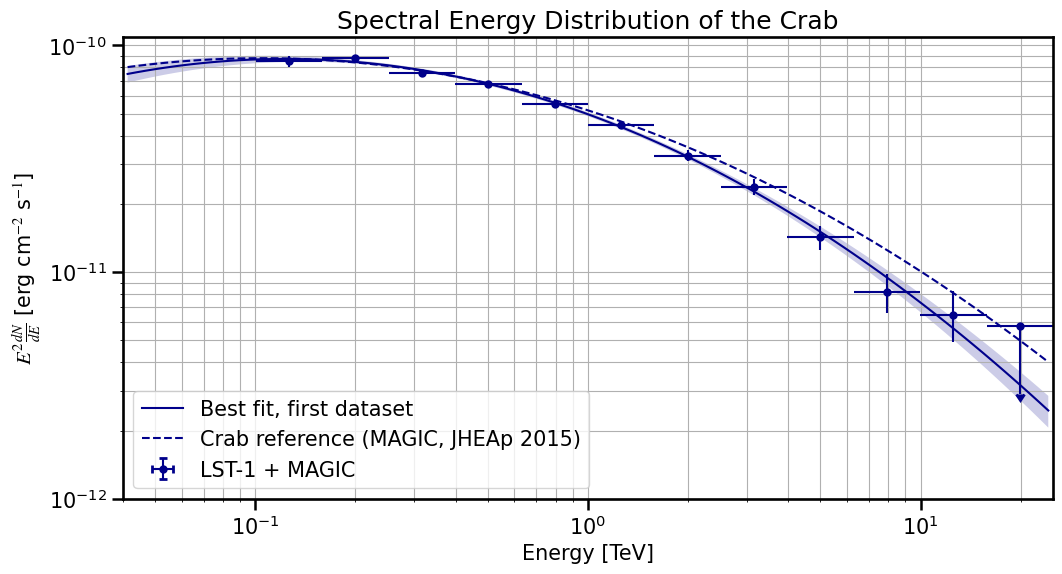

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

energy_bounds = energy_axis.edges[[0, -1]]

for i in range(len(datasets)):

    # --- flux points --- #
    flux_points[i].plot(ax=ax,
                        sed_type=sed_type, 
                        label=f'LST-1 + MAGIC',
                        color=colors[i],)


    # --- best fit model --- #
    best_fit_models[i].plot(ax=ax,
                        energy_bounds=energy_bounds,
                        sed_type=sed_type,
                        yunits=yunits,
                        color=colors[i],
                        label='Best fit, first dataset')

    # --- best fit model error --- #
    best_fit_models[i].plot_error(ax=ax,
                              energy_bounds=energy_bounds,
                              sed_type=sed_type,
                              yunits=yunits,
                              facecolor=colors[i],)


# --- reference spectra --- #
for label, model in reference_models.items():
    model.plot(ax=ax,
               energy_bounds=energy_bounds,
               sed_type=sed_type,
               yunits=yunits,
               label=label,
               linestyle='--',)

ax.set_title(f'Spectral Energy Distribution of the {source_name}')

ax.set_ylim(1e-12)
ax.set_ylabel('$E^2\\frac{dN}{dE}$ [erg cm$^{-2}$ s$^{-1}$]')
ax.grid(which='both')
ax.legend(loc='lower left')
plt.show()

### Computing the light curve

For the light curve, we assume that the spectral shape parameters, $\alpha$ and $\beta$, do not change over the different time bins, i.e. we freeze them at their best-fit values achieved above.

In [13]:
frozen_params = ['alpha', 'beta']

sky_models = [SkyModel(spectral_model=best_fit_models[i].copy(), name=source_name) for i in range(len(datasets))]

for i in range(len(datasets)):
    
    sky_model = SkyModel(spectral_model=best_fit_models[i].copy(), name=source_name)
    
    # freeze the spectral parameters
    for param in frozen_params:
        sky_model.parameters[param].frozen = True

    # Add the model to the datasets
    datasets[i].models = [sky_model]
    sky_models.append(sky_model)
    print(sky_model)

SkyModel

  Name                      : Crab
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.10e-11   +/- 6.2e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.536                   
    beta                  (frozen):      0.128                   




Now we create a `LightCurveEstimator`.

We must set energy edges and time intervals to be used to compute the light curve. If we adopt `time_intervals=None` we will get a run-wise LC, if instead we give it a list of Astropy Time objects, we can create e.g. a daily binned LC.

In [14]:
energy_edges = energy_axis.edges[[1,-1]]

time_intervals = None # `None` automatically makes a 'run-wise' LC.


# create a light curve estimator
light_curve_estimator = LightCurveEstimator(energy_edges=energy_edges,
                                            time_intervals=time_intervals,
                                            source=source_name,
                                            selection_optional='all')

# run the light curve estimator to the datasets
light_curves = []
for i in range(len(datasets)):
    print(f'\nRunning the light curve estimator for {i+1}# dataset...')
    light_curve = light_curve_estimator.run(datasets=datasets[i])
    light_curves.append(light_curve)
    
    # show the light curve table
    display(light_curve.to_table(sed_type='flux', format='lightcurve')[:5])



Running the light curve estimator for 1# dataset...


time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,44]","float64[1,44]",float64[1],bool[1],"float64[1,44]",bool[1],"float64[1,11]","float64[1,11]"
59171.983648585716,59171.9953684448,1.2584989506418267,0.06335278435066316,24.999999999999996,7.008140872453168e-10,5.0544015679140103e-11,5.143573885430214e-11,4.9666561895402986e-11,8.054966791116624e-10,336.2155803770981,18.336182273774934,302.3424627506552 .. nan,247.12338256835938 .. nan,8.930409211401964,False,302.0 .. nan,True,0.2 .. 4.999999999999999,190.77895232124754 .. 1316.5587968845555
59198.89443178897,59198.90443634765,1.2584989506418267,0.06335278435066316,24.999999999999996,1.1057808922076966e-09,1.0377870026174987e-10,1.0622197696619186e-10,1.0137862575069155e-10,1.3232079138541916e-09,221.16165406302608,14.871504767945511,nan .. nan,nan .. nan,18.961133374174114,False,nan .. nan,True,0.2 .. 4.999999999999999,167.4570555281928 .. 350.78114734308417
59198.90560973238,59198.91539958709,1.2584989506418267,0.06335278435066316,24.999999999999996,8.822085083991355e-10,7.118401652358949e-11,7.267008157563613e-11,6.972352413035474e-11,1.0305722440597151e-09,289.0249498103362,17.000733802113842,nan .. nan,nan .. nan,14.843979651819593,False,nan .. nan,True,0.2 .. 4.999999999999999,192.23178999547216 .. 700.8225433412425
59198.916665688004,59198.92610935184,1.2584989506418267,0.06335278435066316,24.999999999999996,7.596532322492362e-10,6.037544341854618e-11,6.149591929900294e-11,5.930873582618498e-11,8.852274815721852e-10,275.10680781260413,16.5863440158645,nan .. nan,nan .. nan,11.022784233294688,False,nan .. nan,True,0.2 .. 4.999999999999999,167.35261133929333 .. 993.2260743746211
59198.927843031706,59198.93682358211,1.2584989506418267,0.06335278435066316,24.999999999999996,7.843887061275479e-10,6.485880441753388e-11,6.610047186850479e-11,6.363795169089538e-11,9.191254566278114e-10,252.21576158773593,15.88130226359715,nan .. nan,nan .. nan,2.025270272114997,False,nan .. nan,True,0.2 .. 4.999999999999999,149.0632600726993 .. 857.3693440985411


### LC plot

Finally, we plot the LCs and compare them to the Crab reference flux.

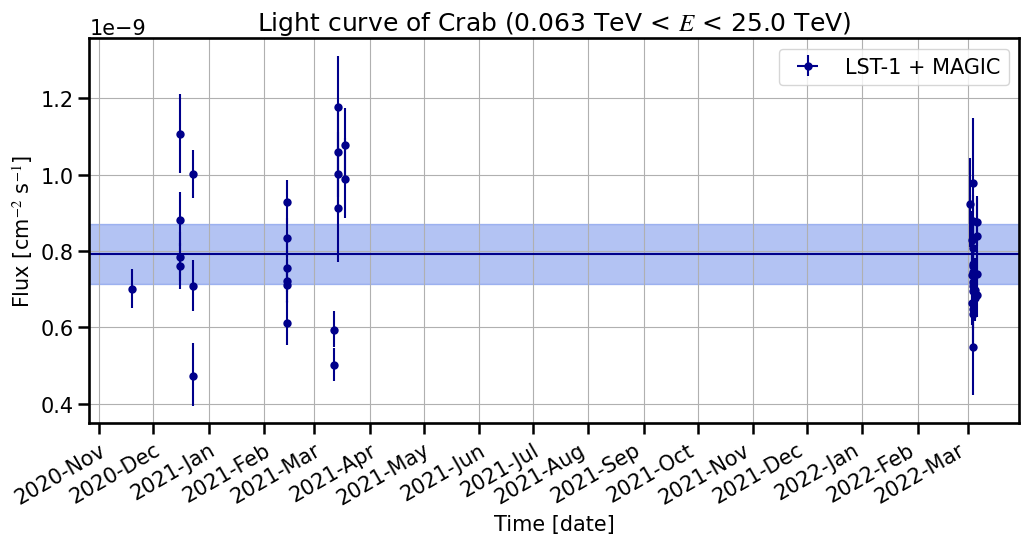

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))

# plot the light curve
for i in range(len(datasets)):
    light_curves[i].plot(ax=ax,
                        sed_type='flux', 
                        label=f'LST-1 + MAGIC', 
                        color=colors[i])
    
mean_flux = np.mean(light_curves[0].to_table(format='lightcurve', sed_type='flux')['flux'])
stdv_flux = np.std(light_curves[0].to_table(format='lightcurve', sed_type='flux')['flux'])/2
ax.axhline(mean_flux)
ax.axhspan(mean_flux-stdv_flux, mean_flux+stdv_flux, color='royalblue', alpha=0.4)

    
# plot the reference flux
# for label, model in reference_models.items():
    
#     integ_flux = model.integral(energy_edges[0], energy_edges[1])
#     ax.axhline(integ_flux, label=label, linestyle='--', color='deeppink')
    
energy_range = f'{energy_edges[0]:.3f} < $E$ < {energy_edges[1]:.1f}'

ax.set_title(f'Light curve of {source_name} ({energy_range})')
ax.set_ylabel('Flux [cm$^{-2}$ s$^{-1}$]')
ax.set_xlabel('Time [date]')

# ax.set_xlim(18570, 18590)
ax.legend()
ax.set_yscale('linear')
ax.grid()

ax.xaxis.set_major_locator(MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))

plt.show()